In [ ]:
!nvidia-smi

Thu Sep 14 03:00:42 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## Making essential imports
import os
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf

Grescale

In [ ]:
import os
import shutil

# Set the path to the "original" folder containing the class subfolders
original_folder = "path/to/original"

# Set the path to the folder where you want to merge all the images
merged_folder = "path/to/merged/folder"

# Create the merged folder if it doesn't exist
if not os.path.exists(merged_folder):
    os.makedirs(merged_folder)

# Loop through each class subfolder in the "original" folder
for class_folder in os.listdir(original_folder):
    class_folder_path = os.path.join(original_folder, class_folder)

    if os.path.isdir(class_folder_path):
        # Get the list of images in the class subfolder
        class_images = os.listdir(class_folder_path)

        # Copy images from the class subfolder to the merged folder
        for image_file in class_images:
            src_path = os.path.join(class_folder_path, image_file)
            dest_path = os.path.join(merged_folder, image_file)
            shutil.copy(src_path, dest_path)

print("All images from the four classes merged into a single folder successfully!")

In [ ]:
from PIL import Image
import os

# Define the input folder containing your images
input_folder = '/content/drive/MyDrive/Research HIRL/Cardiac US/dynamic/Images and mask of cardiac V1/Images'

# Define the output folder where grayscale images will be saved
output_folder = '/content/segmented'

# Create the output folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Loop through all the image files in the input folder
for filename in os.listdir(input_folder):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        # Open the image
        image = Image.open(os.path.join(input_folder, filename))

        # Convert the image to grayscale
        gray_image = image.convert('L')

        # Save the grayscale image with the same filename in the output folder
        gray_image.save(os.path.join(output_folder, filename))

print("Conversion to grayscale completed.")

Conversion to grayscale completed.


In [ ]:
framObjTrain = {'img': [],
                'mask': []
               }

def LoadData(frameObj=None, imgPath=None, maskPath=None, shape=224):
    imgNames = os.listdir(imgPath)

    imgAddr = imgPath + '/'
    maskAddr = maskPath + '/'

    for imgName in imgNames:
        # Check if the file is an image file
        if imgName.endswith('.jpg'):
            img = plt.imread(imgAddr + imgName)
            maskName = imgName.split('.jpg')[0] + '.jpg'
            mask = plt.imread(maskAddr + maskName)

            img = cv2.resize(img, (shape, shape))
            mask = cv2.resize(mask, (shape, shape))

            frameObj['img'].append(img)
            frameObj['mask'].append(mask)

    return frameObj


In [ ]:
framObjTrain = LoadData( framObjTrain, imgPath = '/content/Images'
                        , maskPath = '/content/Masks'
                         , shape = 224)

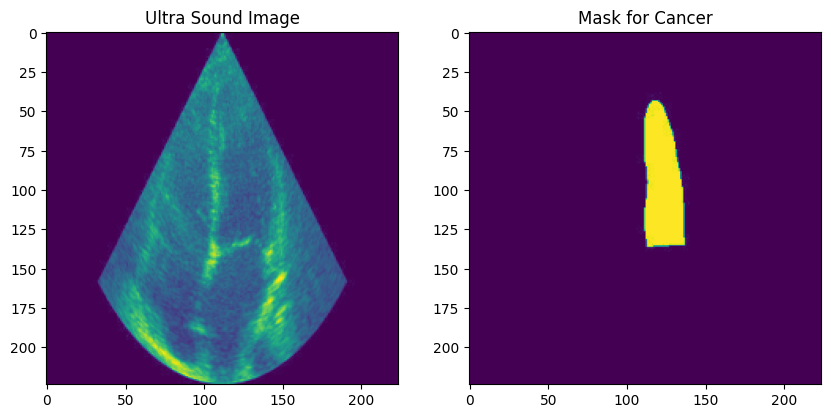

In [ ]:
## displaying data loaded by our function
plt.figure(figsize = (10, 7))
plt.subplot(1,2,1)
plt.imshow(framObjTrain['img'][1])
plt.title('Ultra Sound Image')
plt.subplot(1,2,2)
plt.imshow(framObjTrain['mask'][1])
plt.title('Mask for Cancer')
plt.show()

In [ ]:
pip install superml

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(framObjTrain['img'], framObjTrain['mask'], test_size = 0.30, random_state = 42)

In [ ]:
def Conv2dBlock(inputTensor, numFilters, kernelSize = 3, doBatchNorm = True):
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (inputTensor)

    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)

    x =tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (x)
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Activation('relu')(x)

    return x

def GiveMeUnet(inputImage, numFilters = 16, droupouts = 0.1, doBatchNorm = True):
    c1 = Conv2dBlock(inputImage, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)
    p1 = tf.keras.layers.Dropout(droupouts)(p1)

    c2 = Conv2dBlock(p1, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)
    p2 = tf.keras.layers.Dropout(droupouts)(p2)

    c3 = Conv2dBlock(p2, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)
    p3 = tf.keras.layers.Dropout(droupouts)(p3)

    c4 = Conv2dBlock(p3, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)
    p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)
    p4 = tf.keras.layers.Dropout(droupouts)(p4)

    c5 = Conv2dBlock(p4, numFilters * 16, kernelSize = 3, doBatchNorm = doBatchNorm)

    u6 = tf.keras.layers.Conv2DTranspose(numFilters*8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    u6 = tf.keras.layers.Dropout(droupouts)(u6)
    c6 = Conv2dBlock(u6, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)

    u7 = tf.keras.layers.Conv2DTranspose(numFilters*4, (3, 3), strides = (2, 2), padding = 'same')(c6)

    u7 = tf.keras.layers.concatenate([u7, c3])
    u7 = tf.keras.layers.Dropout(droupouts)(u7)
    c7 = Conv2dBlock(u7, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)

    u8 = tf.keras.layers.Conv2DTranspose(numFilters*2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    u8 = tf.keras.layers.Dropout(droupouts)(u8)
    c8 = Conv2dBlock(u8, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)

    u9 = tf.keras.layers.Conv2DTranspose(numFilters*1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    u9 = tf.keras.layers.Dropout(droupouts)(u9)
    c9 = Conv2dBlock(u9, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)

    output = tf.keras.layers.Conv2D(1, (1, 1), activation = 'sigmoid')(c9)
    model = tf.keras.Model(inputs = [inputImage], outputs = [output])

    return model

# Model Instantiation

In [ ]:
batch_size = 128
inputs = tf.keras.layers.Input((224, 224, 1))
model = GiveMeUnet(inputs, droupouts= 0.3)
model.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'] )
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 1)]        0         []                            
                                                                                                  
 conv2d_38 (Conv2D)          (None, 224, 224, 16)         160       ['input_3[0][0]']             
                                                                                                  
 batch_normalization_36 (Ba  (None, 224, 224, 16)         64        ['conv2d_38[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_36 (Activation)  (None, 224, 224, 16)         0         ['batch_normalization_36

In [ ]:
hisVal = model.fit(np.array(X_train), np.array(y_train), batch_size = batch_size, epochs = 100)

Epoch 1/100
11/11 [==============================] - 50s 3s/step - loss: -51.1425 - accuracy: 0.6711
Epoch 2/100
11/11 [==============================] - 16s 1s/step - loss: -116.5724 - accuracy: 0.7690
Epoch 3/100
11/11 [==============================] - 16s 1s/step - loss: -137.8803 - accuracy: 0.8577
Epoch 4/100
11/11 [==============================] - 16s 1s/step - loss: -150.5038 - accuracy: 0.8872
Epoch 5/100
11/11 [==============================] - 16s 1s/step - loss: -159.6833 - accuracy: 0.8936
Epoch 6/100
11/11 [==============================] - 16s 1s/step - loss: -169.7504 - accuracy: 0.8948
Epoch 7/100
11/11 [==============================] - 16s 1s/step - loss: -178.9187 - accuracy: 0.8935
Epoch 8/100
11/11 [==============================] - 16s 1s/step - loss: -187.5878 - accuracy: 0.8906
Epoch 9/100
11/11 [==============================] - 16s 1s/step - loss: -195.4840 - accuracy: 0.8874
Epoch 10/100
11/11 [==============================] - 16s 1s/step - loss: -202.6281

In [ ]:
retVal = model.fit(np.array(X_test), np.array(y_test), epochs = 100)

Epoch 1/100
19/19 [==============================] - 10s 524ms/step - loss: -232.9486 - accuracy: 0.9031
Epoch 2/100
19/19 [==============================] - 7s 368ms/step - loss: -229.2673 - accuracy: 0.8835
Epoch 3/100
19/19 [==============================] - 7s 377ms/step - loss: -231.0169 - accuracy: 0.8749
Epoch 4/100
19/19 [==============================] - 7s 375ms/step - loss: -232.3773 - accuracy: 0.8785
Epoch 5/100
19/19 [==============================] - 7s 371ms/step - loss: -232.8181 - accuracy: 0.8782
Epoch 6/100
19/19 [==============================] - 7s 366ms/step - loss: -232.9083 - accuracy: 0.8842
Epoch 7/100
19/19 [==============================] - 7s 366ms/step - loss: -232.9608 - accuracy: 0.8841
Epoch 8/100
19/19 [==============================] - 7s 363ms/step - loss: -233.0246 - accuracy: 0.8901
Epoch 9/100
19/19 [==============================] - 7s 363ms/step - loss: -233.0050 - accuracy: 0.8887
Epoch 10/100
19/19 [==============================] - 7s 361ms/

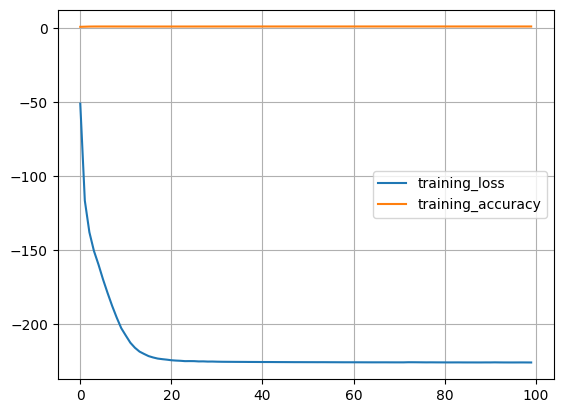

In [ ]:
plt.plot(hisVal.history['loss'], label = 'training_loss')
plt.plot(hisVal.history['accuracy'], label = 'training_accuracy')
plt.legend()
plt.grid(True)

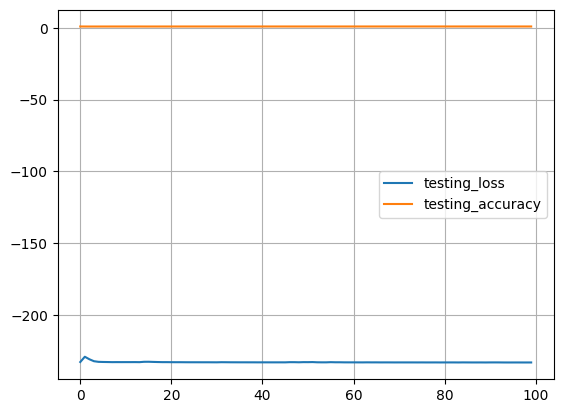

In [ ]:
plt.plot(retVal.history['loss'], label = 'testing_loss')
plt.plot(retVal.history['accuracy'], label = 'testing_accuracy')
plt.legend()
plt.grid(True)

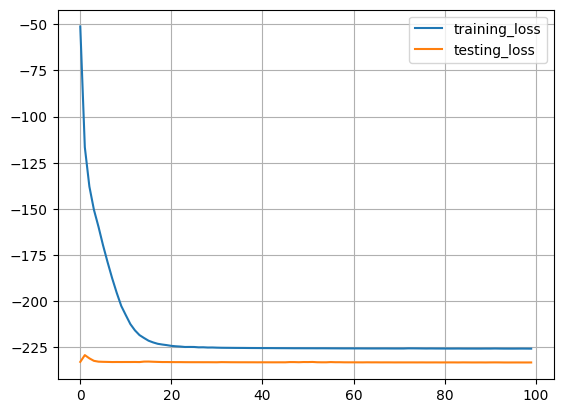

In [ ]:
plt.plot(hisVal.history['loss'], label = 'training_loss')
plt.plot(retVal.history['loss'], label = 'testing_loss')
plt.legend()
plt.grid(True)

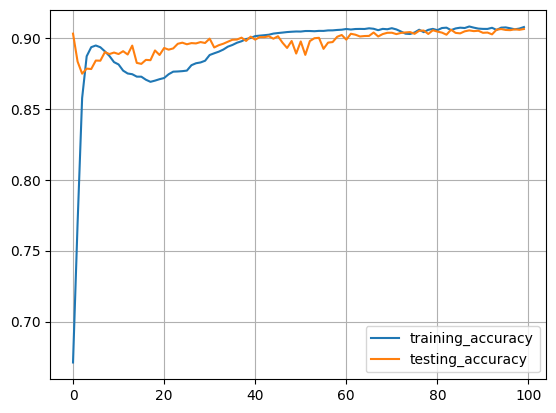

In [ ]:
plt.plot(hisVal.history['accuracy'], label = 'training_accuracy')
plt.plot(retVal.history['accuracy'], label = 'testing_accuracy')
plt.legend()
plt.grid(True)

In [ ]:
#Testing
def predict16 (valMap, model, shape = 224):
    ## getting and proccessing val data
    img = valMap['img'][0:16]
    mask = valMap['mask'][0:16]
    #mask = mask[0:16]

    imgProc = img [0:16]
    imgProc = np.array(img)

    predictions = model.predict(imgProc)


    return predictions, imgProc, mask


def Plotter(img, predMask, groundTruth):
    plt.figure(figsize=(9,9))

    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.title(' image')

    plt.subplot(1,3,2)
    plt.imshow(predMask)
    plt.title('Predicted mask')

    plt.subplot(1,3,3)
    plt.imshow(groundTruth)
    plt.title('Actual mask')

1/1 [==============================] - 3s 3s/step


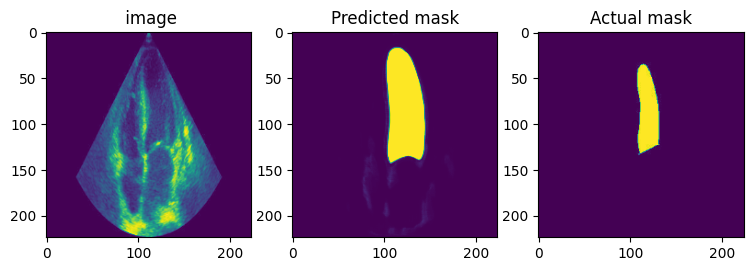

In [ ]:
sixteenPrediction, actuals, masks = predict16(framObjTrain, model)
Plotter(actuals[11], sixteenPrediction[11][:,:,0], masks[11])

In [ ]:
cv2.imwrite(r'test3.png',sixteenPrediction[1][:,:,0])

True

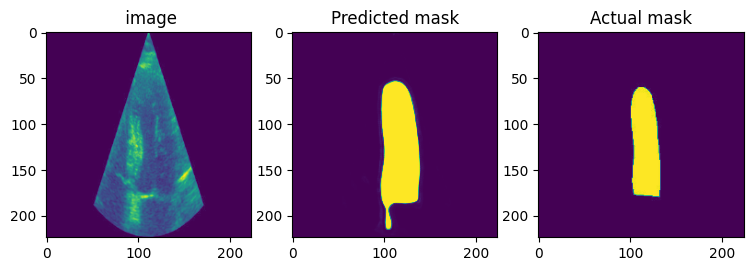

In [ ]:
Plotter(actuals[2], sixteenPrediction[2][:,:,0], masks[2])

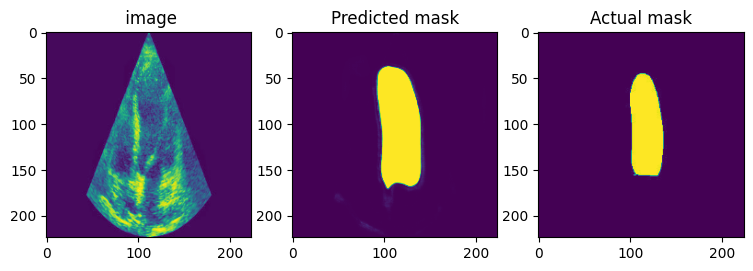

In [ ]:
Plotter(actuals[5], sixteenPrediction[5][:,:,0], masks[5])

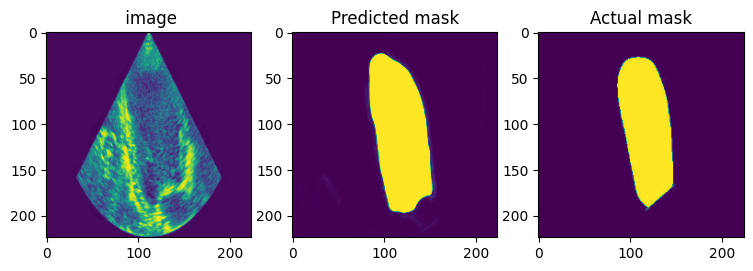

In [ ]:
Plotter(actuals[7], sixteenPrediction[7][:,:,0], masks[7])

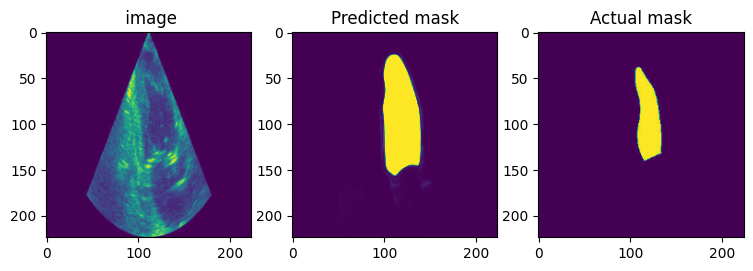

In [ ]:
Plotter(actuals[8], sixteenPrediction[8][:,:,0], masks[8])

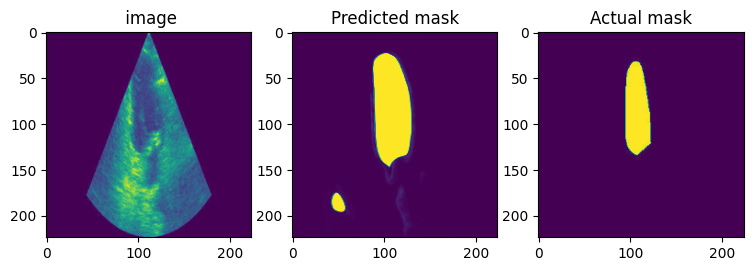

In [ ]:
Plotter(actuals[9], sixteenPrediction[9][:,:,0], masks[9])

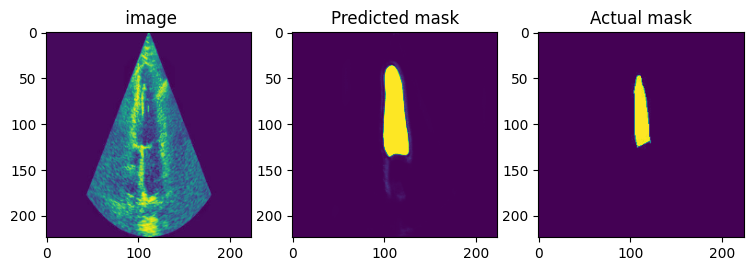

In [ ]:
Plotter(actuals[10], sixteenPrediction[10][:,:,0], masks[10])

In [ ]:
model.save('Cardiac_Seg_data.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
#cp -r '/content/Cardiac Unet RS.h5' '/content/drive/MyDrive/dynamic'